In [1]:
## importing necessary libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats as st
import scipy.stats as st
import os, re
from tqdm import tqdm
import numpy as np
from matplotlib import ticker as mtick
import cmasher as cmr
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, make_scorer
from sklearn.utils import shuffle
from scipy import stats as st
from sklearn.feature_selection import mutual_info_regression
warnings.filterwarnings('ignore')
sns.set_style('white')

## setting up some parameters for making a clean and sound data visualization:
from matplotlib import rcParams
rcParams['figure.figsize']= (10.5,5)
rcParams['axes.linewidth']=0.3
rcParams['axes.labelsize']=15
rcParams['axes.labelweight']='semibold'
rcParams['axes.titlesize']=18
rcParams['axes.titleweight']='semibold'
rcParams['axes.edgecolor']='grey'
rcParams['font.stretch']='semi-condensed'
rcParams['font.family']='sans-serif'
rcParams['legend.frameon']=False
rcParams['legend.fontsize']=10.5
rcParams['ytick.labelsize']=12.5
rcParams['xtick.labelsize']=12.5
rcParams['axes.spines.top']=False
rcParams['axes.spines.right']=False

In [15]:
## Print out No of rows and columns in a dataframe:
def data_shape(data):
    print('No of Rows: {a}\nNo of Columns:{b}'.format(a= data.shape[0], 
                                                      b= data.shape[1]))
    

## Funtion for encoding some categorial features:
def cat_encoder(series):
    zipped= zip(series.value_counts().sort_values().index, range(series.nunique()))
    dicts= dict(zipped)
    return series.map(dicts)

## Function for standard scaling of features:
def standard_scaler(series, ddof=None):
    if ddof:
        sd= np.std(series, ddof=ddof)
    else:
        sd= np.std(series)
    return (series-series.mean())/sd

## Function for Mix-Max Scaling (Normalization) of features:
def minmax_scaler(series):
    return(series-series.min())/(series.max()- series.min())    

## Function for relative frequency of a variable:
def relative_freq(series):
    return series/series.sum()

## Function for generating random colors:
def random_colors(size=1):
    import random
    return ['#'+''.join([i for i in shuffle('abcdef0123456789')][:6]) for i in range(size)]

def rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    import numpy as np
    return np.sqrt(mean_squared_error(y_true, y_pred))

def outliers(data):
    q3= np.quantile(data, 0.75)
    q1= np.quantile(data, 0.25)
    iqr= q3-q1
    
    ll= q1- (1.5*iqr)
    ul= q3+ (1.5*iqr)
    
    return ((data< ll) | (data>ul))

In [576]:
## Function for computing p-values and z-score for One-sample hypothesis testing: 
def one_sample_ztest(x, hyp_mean,alpha, alternative= 'two-sided'):
    '''
    x: [array or list like]
    hyp_mean: Hypothesized Mean int|float
    alpha= significance float
    alternative: 
        'two-sided'
        'larger'
        'smaller'
    '''
    hyp_mean= hyp_mean
    mu= x.mean()
    std= np.std(x)
    se= std/(len(x)**0.5)
    z= (mu-hyp_mean)/se
    if alternative=='two-sided': p_val= (1-st.norm.cdf(abs(z)))**2
    else: p_val= (1-st.norm.cdf(abs(z)))
    return z, p_val

## Function to print out hypothesis results:
def results(p_val, alpha):
    if p_val<alpha:
        print('We reject the Null hypothesis(H0) with p-value:{:.5f}'.format(p_val))
    else:
        print('We failed to reject the H0 with p-value:{:.5f}'.format(p_val))
    
### Function for estimating confidence intervals:
def intervals(x, significance):
    mu= x.mean() # sample mean
    sigma= x.std() # sample std dev
    n= len(x) # size
    z= abs(st.norm.ppf((1-significance)/2)) ## get z-critical value
    se= sigma/(n**0.5) ## Compute standard error of mean
    l, r= mu-(z*se), mu+(z*se) ## estimate intervals
    return l,r


def contingency_table(data):
    d=[]
    grand_total= np.sum(data)
    for j in range(data.shape[1]):
        for i in range(data.shape[0]):
             d.append(data[i].sum()*np.sum(data, axis=0)[j])

    return (np.array(d).reshape(data.shape[1],-1).T)/grand_total

## defining a function for testing in independence between the variables: 
def chi_square(data):
    df= (data.shape[0]-1)* (data.shape[1]-1)
    e= contingency_table(data)
    chi= np.sum(((data-e)**2)/e)
    p= 1-st.chi2.cdf(abs(chi),df= df)
    return chi, p

In [843]:
df= pd.read_csv('general_data.csv')
df.columns=df.columns.str.lower()
df.head()

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,employeecount,employeeid,gender,...,numcompaniesworked,over18,percentsalaryhike,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [844]:
df.shape

(4410, 24)

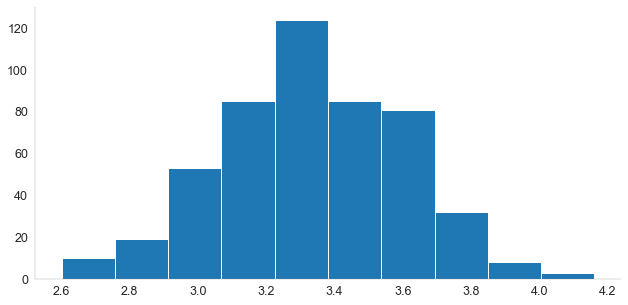

In [845]:
age= (df.age**(1/3))
sample= age.sample(200)
sample= np.random.normal(sample.mean(),sample.std(),500)
plt.hist(sample)
plt.show()

### Confidence Intervals:

#### Estimating population mean:

#### Whether or not the Average age of the employees in the data more than 40?
#### $H\theta: \mu= 3.5$
#### $H1: \mu > 3.5$

In [846]:
z= one_sample_ztest(sample, 3.5, 0.05, 'one-sided')

In [847]:
results(z[1],0.05 )

TypeError: 'tuple' object is not callable

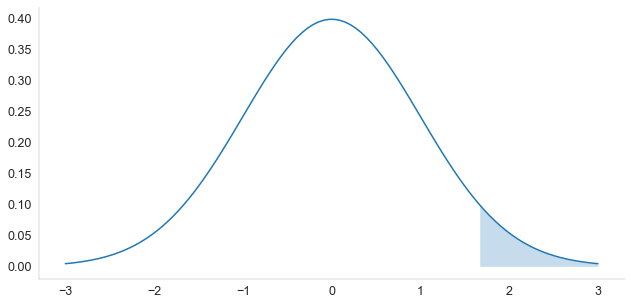

In [848]:
x= np.linspace(-3,3,100)
pdf= st.norm.pdf(x)
plt.plot(x,pdf)
plt.fill_between(x,pdf, where= (x > 1.64), alpha=0.25)

#### Whether or not the Average age of the employees in the data more than 40?
#### $H\theta: \mu= 3.5$
#### $H1: \mu \neq 3.5$

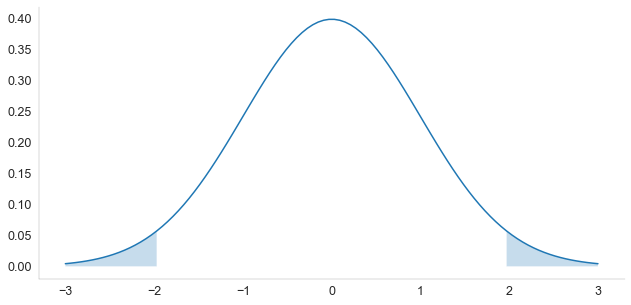

In [850]:
x= np.linspace(-3,3,100)
pdf= st.norm.pdf(x)
plt.plot(x,pdf)
plt.fill_between(x,pdf, where= (abs(x) > 1.96), alpha=0.25)

### Estimation population proportions:

#### $H\theta: \hat P = 0.15$
#### $H1: \hat P \neq 0.15$

In [851]:
sample= df[df.gender=='Female'].sample(120)

In [852]:
p= (sample.attrition=='Yes').mean()
n= (sample.attrition=='Yes').sum()
se= np.sqrt((p*(1-p))/n)
z= (p-0.15)/se

In [853]:
p_val= (1-st.norm.cdf(abs(z)))*2

Text(0.2, 0.3, 'z')

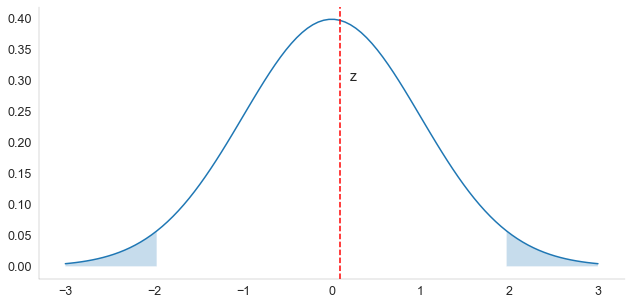

In [854]:
x= np.linspace(-3,3,100)
pdf= st.norm.pdf(x)
plt.plot(x,pdf)
plt.fill_between(x,pdf, where= (abs(x) > 1.96), alpha=0.25)
plt.axvline(z, ls='--', color='red')
plt.annotate(xy= (0.2,0.30), text='z', fontsize= 14)

### Difference in population proportions:

#### Is there any significant difference in attrition between two genders:
#### $H\theta: \hat P_M = \hat P_F$
#### $H1: \hat P_M \neq \hat P_F$ 

In [855]:
sample= pd.crosstab(df.attrition, df.gender).T
sample= sample.apply(lambda x: x/x.sum())
pf= sample['Yes'][0]
pm= sample['Yes'][1]

In [856]:
nf= (df.gender=='Female').sum()
nm= (df.gender=='Male').sum()

In [857]:
phat= (pm+pf)/(nm+nf)

In [858]:
se= np.sqrt((phat*(1-phat))*((1/pm)+ (1/pf)))
z= ((pm-pf) -0)/se

In [859]:
pval= 2*(1-st.norm.cdf(abs(z)))
print('We reject the H0 as p-value < 0.05, which means there is significant difference between Male and Female proportion who have attrited.')

We reject the H0 as p-value < 0.05, which means there is significant difference between Male and Female proportion who have attrited.


#### Test for difference in population means:

#### $ H\theta: \mu_{Attrited}= \mu_{un-attrited}$
#### $ H1: \mu_{Attrited} \neq \mu_{un-attrited}$

In [860]:
x1= age[df.attrition=='Yes'].sample(200)
x2= age[df.attrition=='No'].sample(200)

In [861]:
def two_sample_test(x1, x2, hyp=0, method='unpooled', alternative='two-sided'):
    mu1=np.mean(x1)
    mu2= np.mean(x2)
    s1= np.std(x1)
    s2= np.std(x2)
    n1, n2= len(x1), len(x2)
    md= mu1-mu2
    if method=='unpooled':
        se= np.sqrt((s1**2/n1)+(s2**2/n2))
    else:
        dof= n1+n2-2
        sp= np.sqrt((((n1-1)*(s1**2))+ ((n2-1)*(s2**2)))/dof)
        se= sp*np.sqrt((1/n1)+ (1/n2))
        
    z= (md-hyp)/(se)
    
    if alternative=='two-sided':
        p_val= (1-st.norm.cdf(abs(z)))*2
    else:
        p_val= (1-st.norm.cdf(abs(z)))
        
    return z, p_val

In [862]:
results= two_sample_test(x1, x2)
if results[1]< 0.05:
    print('We reject the H0 as p-val < 0.05')
else:
    print('We failed to reject the H0 as p-val > 0.05')

We reject the H0 as p-val < 0.05


In [863]:
def two_sample_intervals(x1, x2, significance,hyp=0, method='unpooled'):
    mu1=np.mean(x1)
    mu2= np.mean(x2)
    s1= np.std(x1)
    s2= np.std(x2)
    n1, n2= len(x1), len(x2)
    md= mu1-mu2
    if method=='unpooled':
        se= np.sqrt((s1**2/n1)+(s2**2/n2))
    else:
        dof= n1+n2-2
        sp= np.sqrt((((n1-1)*(s1**2))+ ((n2-1)*(s2**2)))/dof)
        se= sp*np.sqrt((1/n1)+ (1/n2))
    
    sig= (1-significance)/2
    z_critical= abs(st.norm.ppf(sig))
    
    ll= md - (z_critical*se)
    ul= md + (z_critical*se)
    return ll, ul

In [864]:
two_sample_intervals(x2, x1, significance=.95)

(0.043610836642401535, 0.15708161927682626)

In [865]:
x1.mean(), x2.mean()

(3.215581891851615, 3.315928119811229)

### Chi-square Test ($\chi^2$) for independence

#### $H\theta:$ There is no statistically significance relationship between *Attrition* and *No of companies employee worked.* 
#### $H1:$ There is statistically significant relationship between *Attrition* and *No of companies employee worked.* 

In [866]:
table= pd.crosstab(df.numcompaniesworked, df.attrition).values

In [867]:
results= chi_square(table)

In [868]:
if results[1]< 0.05:
    print('We reject the H0, as p-value < 0.05, which concludes that there is statistically significanct relationship between Attrition and  No of companies  employee worked ')
else:
    print('We failed to reject the H0, as p-value > 0.05, which concludes that there is no statistically significanct relationship between Attrition and No of companies  employee worked ')

We reject the H0, as p-value < 0.05, which concludes that there is statistically significanct relationship between Attrition and  No of companies  employee worked 


In [869]:
dof= (table.shape[0]-1)*(table.shape[1]-1)

In [895]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix

In [871]:
### Imputing missing values:
df.numcompaniesworked= df.numcompaniesworked.fillna(0)
df.totalworkingyears= df.totalworkingyears.fillna(0)
df=df.drop(['employeecount','over18','standardhours'], axis=1)

In [872]:
df.attrition= df.attrition.map({'Yes': 1, 'No': 0})

In [873]:
X= df.drop('attrition', axis=1)
y= df.attrition

In [874]:
le=LabelEncoder()
X[X.select_dtypes('O').columns]= X.select_dtypes('O').apply(lambda x: le.fit_transform(x))
X=standard_scaler(X)

In [875]:
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=42, test_size=.25)

In [892]:
model_dict= {'Logistic Regression': LogisticRegression(),
            'Random Forest': RandomForestClassifier(),
            'Decision Tree': DecisionTreeClassifier(),
            'Naive Bayes': GaussianNB(),
            'SVM': SVC(),
            'Ada Boost': AdaBoostClassifier(),
            'Gradient Boost:': GradientBoostingClassifier(),
            'KNN': KNeighborsClassifier()}

In [916]:
precision_train, precision_test=[],[]
recall_train, recall_test= [],[]
models=[]
for i in tqdm(model_dict.items()):
    lm= i[1]
    lm.fit(X_train, y_train)
    predtrain= lm.predict(X_train)
    predtest= lm.predict(X_test)
    
    precision_train.append(precision_score(y_train, predtrain))
    precision_test.append(precision_score(y_test, predtest))
    
    recall_train.append(recall_score(y_train, predtrain))
    recall_test.append(recall_score(y_test, predtest))
    models.append(i[0])

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.74it/s]


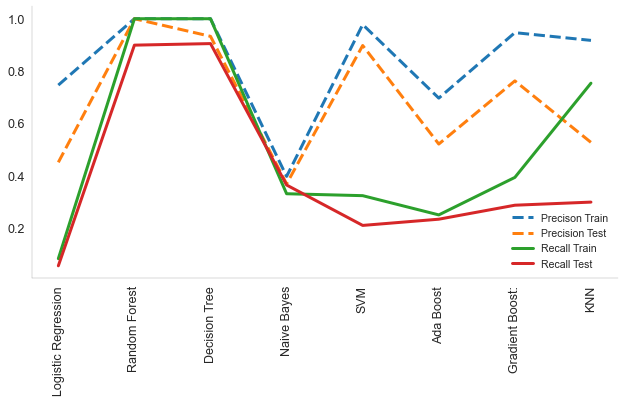

In [919]:
plt.plot(models, precision_train, lw=3,ls='--',label='Precison Train')
plt.plot(models, precision_test, lw=3,ls='--',label='Precision Test')

plt.plot(models, recall_train, lw=3,label='Recall Train')
plt.plot(models, recall_test, lw=3,label='Recall Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [928]:
rf= RandomForestClassifier(n_estimators=2000)
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       935
           1       1.00      0.88      0.94       168

    accuracy                           0.98      1103
   macro avg       0.99      0.94      0.96      1103
weighted avg       0.98      0.98      0.98      1103



              precision    recall  f1-score   support

           0       0.98      1.00      0.99       935
           1       1.00      0.89      0.94       168

    accuracy                           0.98      1103
   macro avg       0.99      0.94      0.97      1103
weighted avg       0.98      0.98      0.98      1103

